In [1]:
using WignerSymbols, PyPlot, LaTeXStrings, DelimitedFiles, LinearAlgebra
using PyCall
LineCollection = matplotlib.collections.LineCollection

PyObject <class 'matplotlib.collections.LineCollection'>

# Dysprosium polarizability using the lines of [Li et al.](https://iopscience.iop.org/article/10.1088/1361-6455/50/1/014005/meta?casa_token=fdHnA09HK5YAAAAA:udMr6w5uNeI5ymUbqNnQTZblKQiRSeYYoepYsFGMrxY2bt5KqtGu9WEa6M7q-kmo-hczrc5g)

In [2]:
const mₑ = 9.109E-31
const c = 2.997E8
const ħ = 1.05457E-34
const e = 1.6022E-19
const a₀ = 5.29177E-11
const ϵ₀ = 8.8542E-12
const au_pol = 1.65E-41
const Eh = ħ^2 / (mₑ * a₀^2)    # Hartree energy
const Ia = 0                    # Nuclear spin

0

In [3]:
# toω(λ) = 2*π*c/λ
toω(λ) = 2*π*137 / λ   # in a.u.
toλ(ω) = 2*π*c/ω

toλ (generic function with 1 method)

The reduced matrix element depends on the oscillator strength $A_{ik}$ through

$|\langle n'J' || \mathbf{d} || nJ \rangle |^2 = \frac{3\pi\epsilon_0\hbar c^3}{\omega_{ik}^3} (2J' + 1) A_{ik}.$

The oscillator strengths can be obtained through the [NIST database](https://physics.nist.gov/cgi-bin/ASD/lines_hold.pl?el=Dy) (click "Dy I," they're labeled $A_{ki}$ in that table).

Following the conventions of Le Kien and other literature, we absorb $\sqrt{2J+1}$ into the reduced matrix element.

In [4]:
linesdat = readdlm("5I8_Spectre_Eexp-2.txt", ',', Float64);
linesdat = sortslices(linesdat, dims = 1, lt = (x, y) -> isless(x[4], y[4]), rev = true);

In [5]:
Jps = linesdat[:, 2]
Js = linesdat[:, 1]
Γs = linesdat[:, 5]
λs = 2*π * 137 ./ linesdat[:, 3]
redMatEls = sqrt.( linesdat[:, 4] );

In [6]:
function α(K, J, ω)
    prefac = Complex(-1)^(K + J + 1) * sqrt(2*K + 1)
    terms = [Complex(-1)^Jp * wigner6j(1, K, 1, J, Jp, J) * redMatEl^2 * ( 1/(toω(λ) - ω - 1im * γ/2) + (-1)^K/(toω(λ) + ω + 1im * γ/2) ) for (Jp, redMatEl, λ, γ) ∈ zip(Jps, redMatEls, λs, Γs) ]
    s = sum(terms)
    return (prefac * s)
end

α (generic function with 1 method)

In [7]:
αs(ω) = 1/sqrt(3 * (2*Js[1] + 1) ) * α(0, Js[1], ω) 
αv(ω) = sqrt(2*Js[1] / ( (Js[1] + 1)*(2*Js[1] + 1) )) * α(1, Js[1], ω)
αt(ω) = -sqrt( 2*Js[1] * (2*Js[1] - 1) / ( 3*(Js[1] + 1) * (2*Js[1] + 1) * (2*Js[1] + 3) ) ) * α(2, Js[1], ω)

αt (generic function with 1 method)

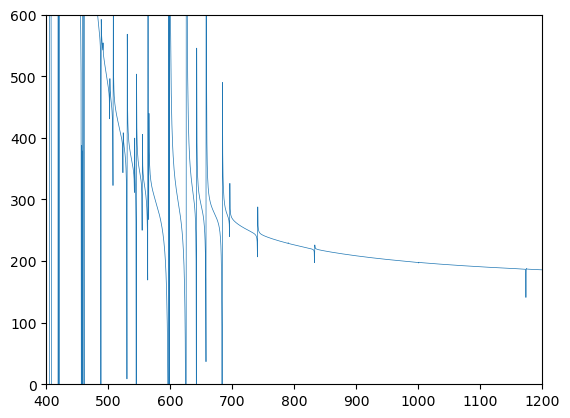

287.8798429662688 + 7.728120802879545e-6im

In [11]:
fig, ax = plt.subplots()
λsp = [400:0.5:1200;]*1e-9

ax.plot(λsp * 1e9, real.([αs(toω(λ / a₀)) for λ ∈ λsp]), label = "Us", lw = 0.5)
# ax.set_ylim([0, 300])
# ax.set_xlim([0, 20])
ax.set_ylim([0, 600])
ax.set_xlim([400, 1200])


αs(toω(741e-9/a₀))

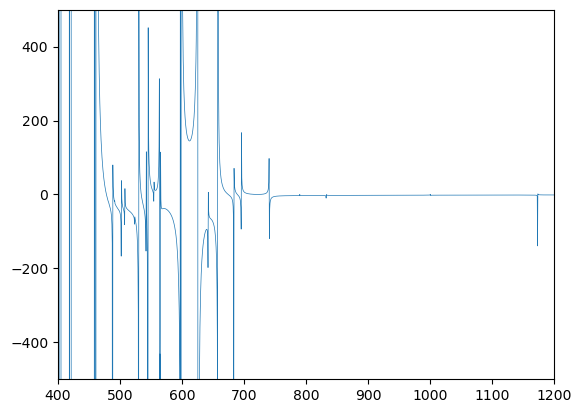

(400.0, 1200.0)

In [191]:
fig, ax = plt.subplots()

ax.plot(1e9 .* λsp, real.([αv(toω(λ / a₀)) for λ ∈ λsp]), lw = 0.5, label = "Us - vector")
# ax.set_ylim([0, 300])
# ax.set_xlim([9e3, 13.4e3])
ax.set_ylim([-5e2, 5e2])
ax.set_xlim([400, 1200])

# vector_calc = readdlm("maxence-vector.csv", ',', Float64)
# ax.plot(1e4./vector_calc[:, 1], vector_calc[:,2], ls = "none", marker = ".", ms = 1, label = "Maxence")
# ax.legend()

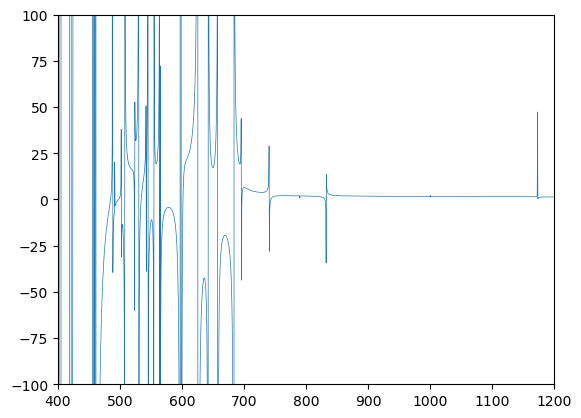

(400.0, 1200.0)

In [12]:
fig, ax = plt.subplots()

tensor_pols = [αt(toω(λ / a₀)) for λ ∈ λsp]

# ax.plot(λs * 1e9, [α_tot(toω(λ)) / au_pol for λ ∈ λs])
ax.plot((λsp * 1e9), real.(tensor_pols), lw = 0.5, label = "Us - vector")
ax.set_ylim([-1e2, 1e2])
ax.set_xlim([400, 1200])

# tensor_calc = readdlm("maxence-tensor.csv", ',', Float64)
# ax.plot(1e4./tensor_calc[:, 1], tensor_calc[:,2], ls = "none", marker = ".", ms = 1, label = "Maxence")
# ax.legend()

## Magic wavelengths for bilayer potentials

When creating a bilayer, we would like opposite spins ($m_J = \pm 8$) to experience very different potentials. Ideally one of them doesn't see any potential at all, while the other is trapped. So far, we've been approximating this by staying close to a $J \rightarrow J + 1$ transition, where $J = 8$ is sufficiently large such that there's a large contrast between Clebsch-Gordan coefficients. (For us the square of the ratio is 1/153, meaning the residual coupling is 153 times weaker.)

Can we do better, though? By calculating the total polarizability for both $m_J = \pm 8$ we can see if there are wavelengths that have a complete tuneout for one of the two polarizations, while having a finite polarizability for the other. 

Following Le Kien _et al._, we calculate the general polarizability as follows:

In [8]:
function uu(K, q, pol)
    function sumterm(K, q, μ, μp, pol)
        # Check if CG is physical
        if μ - q + μp == 0
            Complex(-1)^(q + μp) * pol[μ + 2] * conj(pol[2-μp]) * sqrt(2*K + 1)  * wigner3j(1, K, 1, μ, -q, μp)
        else
            0
        end
    end
    return sum([sumterm(K, q, μ, μp, pol) for μ ∈ (-1, 0, 1) for μp in (-1, 0, 1)])
end

function α_tot(ω, J, mJ, Jp, mJp, pol; Kmax = 2)
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return sum([ α(K, J, ω) * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(8, K, 8, 8, 0, 8) for K ∈ [0:Kmax;] for q ∈ [-K:K;]])
    end
end

function α_tot_precalc(αs, J, mJ, Jp, mJp, pol; Kmax = 2)
    # Same as above, but requires α(K, J, ω) to be precalculated, feed in as array [α(0, J, ω), ..., α(2, J, ω)]
    if abs(mJ - mJp) > 2
        return 0.0
    else
        return sum([ αs[K + 1] * uu(K, q, pol) * Complex(-1)^(J + Ia + K + q - mJ) *
            sqrt((2*J + 1) * (2*Jp + 1)) * wigner3j(J, K, Jp, mJ, q, -mJp) *
            wigner6j(J, K, Jp, J, Ia, J) for K ∈ [0:Kmax;] for q ∈ [-K:K;]])
    end
end



α_tot_precalc (generic function with 1 method)

In [9]:
function normalized_polarization_eigenstates(ω, pol; Kmax = 2, offdiag = true, return_vecs = false)
    αmat = zeros(ComplexF64,17, 17)
    αs = [α(K, 8, ω) for K ∈ 0:2]
    for (i, mJ) ∈ enumerate(-8:8)
        for (j, mJp) ∈ enumerate(mJ:8)
            αmat[i, i+j-1] = α_tot_precalc(αs, 8, mJ, 8, mJp, pol; Kmax = Kmax)
        end
    end
    for (i, mJ) ∈ enumerate(-8:7)
        print(Hermitian(αmat)[i,i+1])
    end
    if offdiag
        if return_vecs
            return eigen(Hermitian(αmat))
        else
            return eigvals(Hermitian(αmat, :U))
        end
    else
        return diag(αmat)
    end
return
end

normalized_polarization_eigenstates (generic function with 1 method)

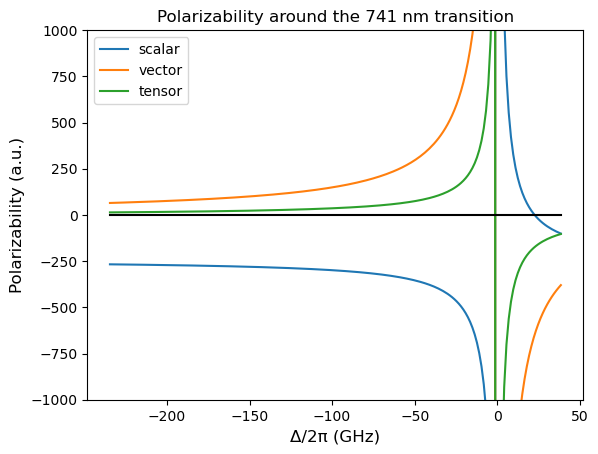

(-1000.0, 1000.0)

In [9]:
λrange = range(740.7e-9, 741.2e-9, length = 200)
λ₀ = 740.7704310604076e-9
fig, ax = plt.subplots()

plot1=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))) for λ ∈ λrange],label="scalar")

plot2=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αv(toω(λ / a₀))) for λ ∈ λrange],label="vector")
plot3=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αt(toω(λ / a₀))) for λ ∈ λrange],label="tensor")

plot4=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [0 for λ ∈ λrange],color="k")

ax.set_xlabel("Δ/2π (GHz)", fontsize = 12)
ax.set_ylabel("Polarizability (a.u.)", fontsize = 12)
ax.set_title("Polarizability around the 741 nm transition")
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles1, labels1)

ax.set_ylim([-1000, 1000])

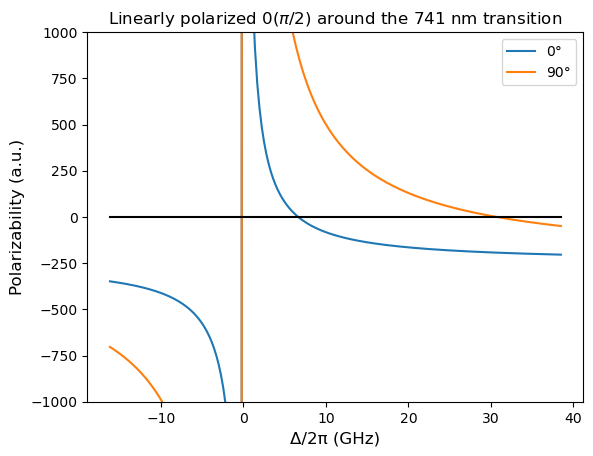

(-1000.0, 1000.0)

In [268]:
λrange = range(740.7e-9, 740.8e-9, length = 200)
λ₀ = 740.7704310604076e-9
fig, ax = plt.subplots()

plot1=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))-αt(toω(λ/ a₀))) for λ ∈ λrange],label="0°")

plot2=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))+0.5*αt(toω(λ/ a₀))) for λ ∈ λrange],label="90°")

plot3=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [0 for λ ∈ λrange],color="k")

ax.set_xlabel("Δ/2π (GHz)", fontsize = 12)
ax.set_ylabel("Polarizability (a.u.)", fontsize = 12)
ax.set_title(L"Linearly polarized $0(\pi/2)$ around the 741 nm transition")
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles1, labels1)

ax.set_ylim([-1000, 1000])

In [9]:
#detune=10^13

latwavelength = c/(c/(740.7704310604076e-9)-1.25e9);
latwavelength = 1064e-9;

println(αs(toω(latwavelength / a₀)));

println(αv(toω(latwavelength/ a₀)));

println(αt(toω(latwavelength/ a₀)));

#println(αs(toω(latwavelength / a₀))-0.5*αt(toω(latwavelength/ a₀)));


193.00305241197046 + 3.3696910388597363e-6im
-1.6622791401779817 - 1.5822395322947257e-6im
1.5125108360270447 + 4.241856030089728e-7im


In [13]:
function get_levels(σp_beam, σm_beam; Kmax = 2, offdiag = true, return_vecs = false)
    levels = zeros(length(σp_beam), 17)
    expsz = zeros(length(σp_beam), 17)
    for i ∈ 1:length(σp_beam)
        pol = [σp_beam[i], 0, σm_beam[i]]
        pol = pol/norm(pol)
        if return_vecs
            vals, vecs = normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)  
            levels[i, :] = (σp_beam[i]^2 + σm_beam[i]^2) * vals
            expsz[i, :] = abs.(vecs.^2)' * [-8.:1.:8.;]
        else
            levels[i, :] = (σp_beam[i] + σm_beam[i]) * normalized_polarization_eigenstates(toω(latwavelength / a₀), pol; Kmax = Kmax, offdiag = offdiag, return_vecs = return_vecs)
        end
    end
    
    if return_vecs
        return levels, expsz
    else
        return levels
    end
end

get_levels (generic function with 1 method)

## Tweezer cartoon

## Lattice cartoon

In [321]:
pol = [1,0,0]
pol = pol/norm(pol)
vals,vecs= normalized_polarization_eigenstates(toω(latwavelength/ a₀), pol; Kmax = 2, offdiag = true, return_vecs = true);

0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im0.0 + 0.0im

Load custom colormap:

## Export data

In [13]:
using WignerSymbols, PyPlot, LaTeXStrings, DelimitedFiles, LinearAlgebra
using PyCall
LineCollection = matplotlib.collections.LineCollection

PyObject <class 'matplotlib.collections.LineCollection'>

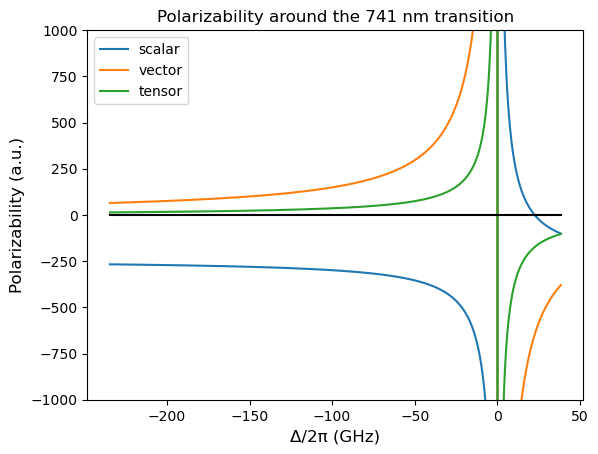

(-1000.0, 1000.0)

In [14]:
const mₑ = 9.109E-31
const c = 2.997E8
const ħ = 1.05457E-34
const e = 1.6022E-19
const a₀ = 5.29177E-11
const ϵ₀ = 8.8542E-12
const au_pol = 1.65E-41
const Eh = ħ^2 / (mₑ * a₀^2)    # Hartree energy
const Ia = 0                    # Nuclear spin

# toω(λ) = 2*π*c/λ
toω(λ) = 2*π*137 / λ   # in a.u.
toλ(ω) = 2*π*c/ω

linesdat = readdlm("5I8_Spectre_Eexp-2.txt", ',', Float64);
linesdat = sortslices(linesdat, dims = 1, lt = (x, y) -> isless(x[4], y[4]), rev = true);

Jps = linesdat[:, 2]
Js = linesdat[:, 1]
Γs = linesdat[:, 5]
λs = 2*π * 137 ./ linesdat[:, 3]
redMatEls = sqrt.( linesdat[:, 4] );

function α(K, J, ω)
    prefac = Complex(-1)^(K + J + 1) * sqrt(2*K + 1)
    terms = [Complex(-1)^Jp * wigner6j(1, K, 1, J, Jp, J) * redMatEl^2 * ( 1/(toω(λ) - ω - 1im * γ/2) + (-1)^K/(toω(λ) + ω + 1im * γ/2) ) for (Jp, redMatEl, λ, γ) ∈ zip(Jps, redMatEls, λs, Γs) ]
    s = sum(terms)
    return (prefac * s)
end

αs(ω) = 1/sqrt(3 * (2*Js[1] + 1) ) * α(0, Js[1], ω) 
αv(ω) = sqrt(2*Js[1] / ( (Js[1] + 1)*(2*Js[1] + 1) )) * α(1, Js[1], ω)
αt(ω) = -sqrt( 2*Js[1] * (2*Js[1] - 1) / ( 3*(Js[1] + 1) * (2*Js[1] + 1) * (2*Js[1] + 3) ) ) * α(2, Js[1], ω)

λrange = range(740.7e-9, 741.2e-9, length = 1000)
λ₀ = 740.7704310604076e-9
fig, ax = plt.subplots()

plot1=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αs(toω(λ / a₀))) for λ ∈ λrange],label="scalar")

plot2=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αv(toω(λ / a₀))) for λ ∈ λrange],label="vector")
plot3=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [real.(-αt(toω(λ / a₀))) for λ ∈ λrange],label="tensor")

plot4=ax.plot(c*(1 ./ λrange .- 1 ./ λ₀ ) ./ 1e9, [0 for λ ∈ λrange],color="k")

ax.set_xlabel("Δ/2π (GHz)", fontsize = 12)
ax.set_ylabel("Polarizability (a.u.)", fontsize = 12)
ax.set_title("Polarizability around the 741 nm transition")
handles1, labels1 = ax.get_legend_handles_labels()
ax.legend(handles1, labels1)

ax.set_ylim([-1000, 1000])